In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import pipeline, DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from transformers import AdamWeightDecay

In [3]:
# Use 'on_bad_lines' instead of 'error_bad_lines' to handle bad lines
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/articles_processed.csv', encoding='utf-8')

data = data[data['Category'] != 4]

In [4]:
data['Category'] = data['Category'].replace(5, 4)

In [5]:
data.Category.unique()

array([1, 2, 4, 3])

In [6]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.head(50000)

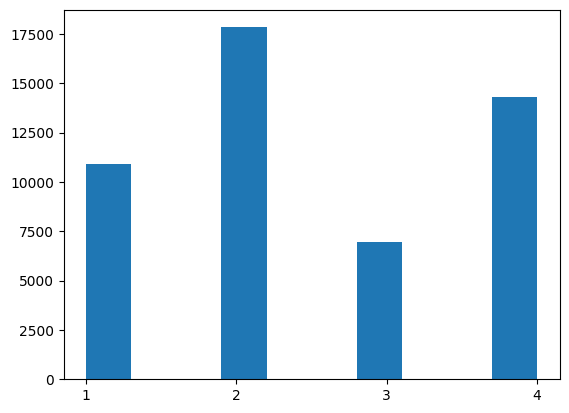

In [7]:
index_to_split = int(0.8*len(data))

X_train = data.Content[:index_to_split]
X_test = data.Content[index_to_split:]

y_train = data.Category[:index_to_split]
y_test = data.Category[index_to_split:]

class_id = data.Category
plt.hist(class_id)
plt.xticks(np.arange(1, 5))
plt.show()

tmp_dataset = data

In [8]:
# the maximum number of words to keep, based on word frequency
NUM_WORDS = 50000

# dimension of the dense embedding that will be used in the embedding layer of the model
EMBEDDING_DIM = 16

# maximum length of all sequences
MAXLEN = 200

# padding strategy
PADDING = 'post'

# token to replace out-of-vocabulary words during text_to_sequence() calls
OOV_TOKEN = ""

# proportion of data used for training
TRAINING_SPLIT = .8
num_unique_categories = 4

In [9]:
# Tokenize văn bản
tokenizer = Tokenizer(num_words=50000, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [10]:
# Pad sequences
max_length = 200  # Độ dài tối đa của mỗi văn bản
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [11]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="distilbert/distilbert-base-uncased")
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

DistilBERT_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert/distilbert-base-uncased")
DistilBERT_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification 

In [12]:
# Tokenize dữ liệu cho PhoBERT
def tokenize_phobert(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="tf"
    )

In [13]:
train_encodings = tokenize_phobert(X_train, DistilBERT_tokenizer, max_length=200)
test_encodings = tokenize_phobert(X_test, DistilBERT_tokenizer, max_length=200)

In [14]:
# Huấn luyện PhoBERT
optimizer = AdamWeightDecay(learning_rate=2e-5)
DistilBERT_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
DistilBERT_model = DistilBERT_model.fit(
    train_encodings['input_ids'], y_train - 1,  # Chuyển nhãn về 0-based
    validation_data=(test_encodings['input_ids'], y_test - 1),
    epochs=3,
    batch_size=16
)

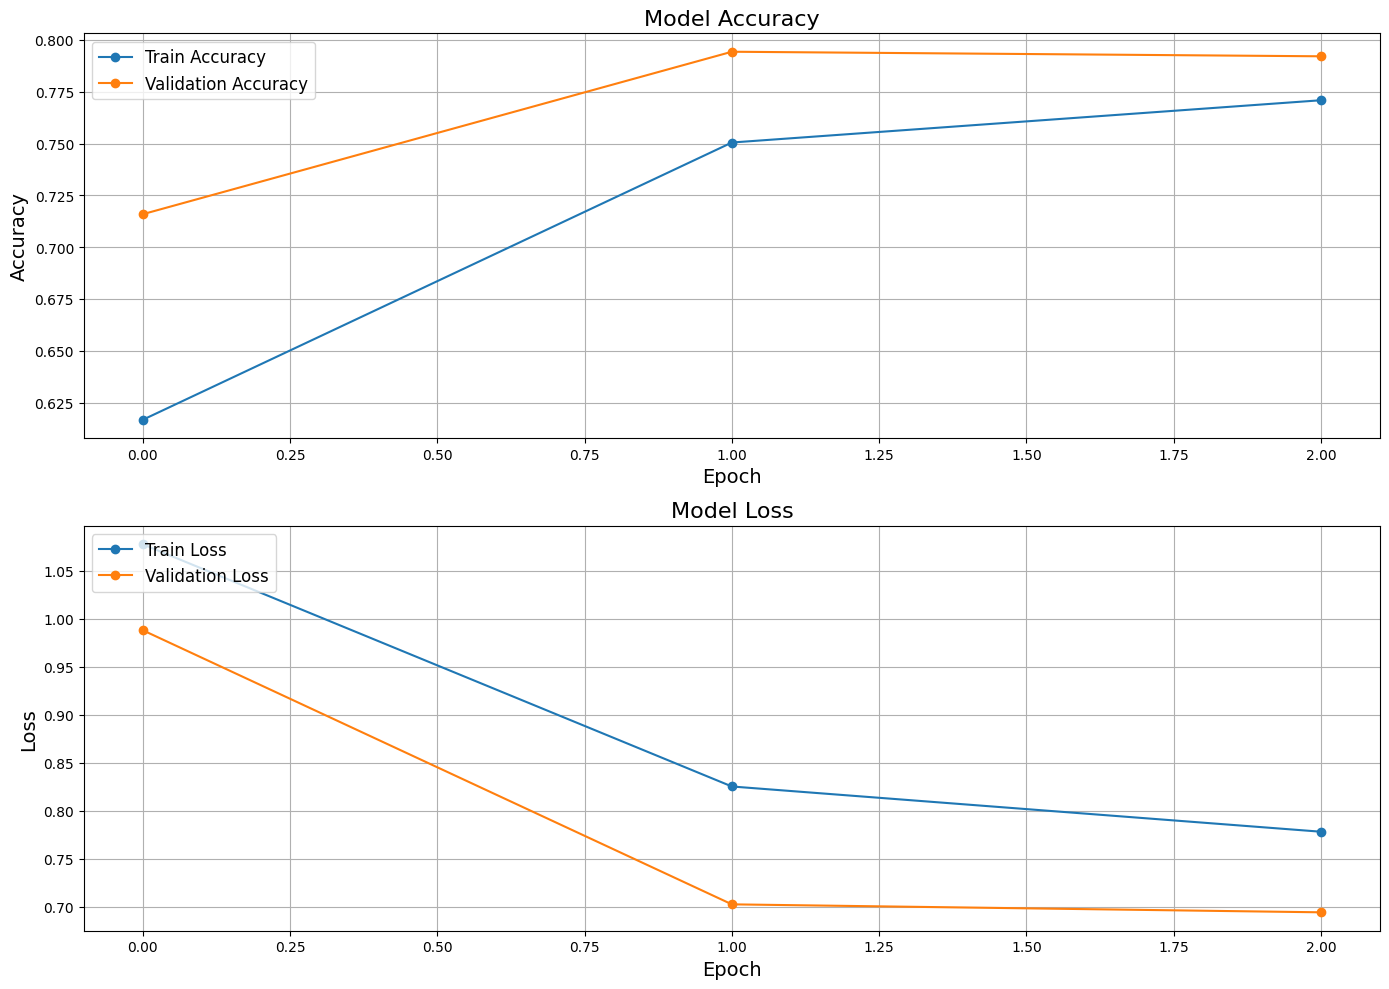

In [16]:
def plot_learning_curve(history):
    plt.figure(figsize=(14, 10))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(DistilBERT_model)